In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import numpy as np

class ConvAE_DCEC(nn.Module):
    def __init__(self, in_channels=3, embedded_dim=10):
        super(ConvAE_DCEC, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2, stride=2), # [16, 16, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, padding=2, stride=2), # [8,8,64]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=0, stride=2), # [3,3,128]
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(128 * 3 * 3, embedded_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedded_dim, 128 * 3 * 3),
            nn.ReLU(),
            nn.Unflatten(1, (128,3,3)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, padding=0, stride=2), # [8,8,64]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, padding=1, stride=2), # [16, 16, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, kernel_size=4, padding=1, stride=2), # [32, 32, 3]
            nn.Tanh() # map to input image scale [-1,1]
        )


    def forward(self, x):
        latent = self.encoder(x)
        return self.decoder(latent)
    
class ConvAE_DCEC_Adjusted(nn.Module):
    def __init__(self, in_channels=3, embedded_dim=10):
        super(ConvAE_DCEC_Adjusted, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4, padding=1, stride=2),  # [16, 16, 32]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, padding=1, stride=2),  # [8, 8, 64]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, padding=1, stride=2),  # [4, 4, 128]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, padding=1, stride=2),  # [2, 2, 256]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Flatten(start_dim=1),
            nn.Linear(256 * 2 * 2, embedded_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedded_dim, 256 * 2 * 2),
            nn.ReLU(),
            nn.Unflatten(1, (256, 2, 2)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # [4, 4, 128]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # [8, 8, 64]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # [16, 16, 32]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, in_channels, kernel_size=4, stride=2, padding=1),  # [32, 32, 3]
            nn.Tanh()  # map to input image scale [-1,1]
        )

    def forward(self, x):
        latent = self.encoder(x)
        return self.decoder(latent)
    
def to_img(x):
    # normalize tensor to [0,1] from [-1,1] for plotting
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x



In [2]:
DATASET_CACHE_DIR = './data'
BATCH_SIZE = 128
#settings from paper
LR = 0.001
N_EPOCHS = 400
USE_GPU = torch.cuda.is_available()

In [3]:
transforms_val = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),
])
transforms_train = T.Compose([
    # T.RandomHorizontalFlip(),
    # T.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    T.ToTensor(),
    T.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),
])


train_loader = DataLoader(CIFAR10(root=DATASET_CACHE_DIR, train=True, download=True, transform=transforms_train), batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4)
test_loader = DataLoader(CIFAR10(root=DATASET_CACHE_DIR, train=False, download=True, transform=transforms_val), batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)

batch = next(iter(train_loader))
print(torch.max(batch[0]))
print(torch.min(batch[0]))


Files already downloaded and verified
Files already downloaded and verified
tensor(1.)
tensor(-1.)


Training loss: 0.12960435045071136


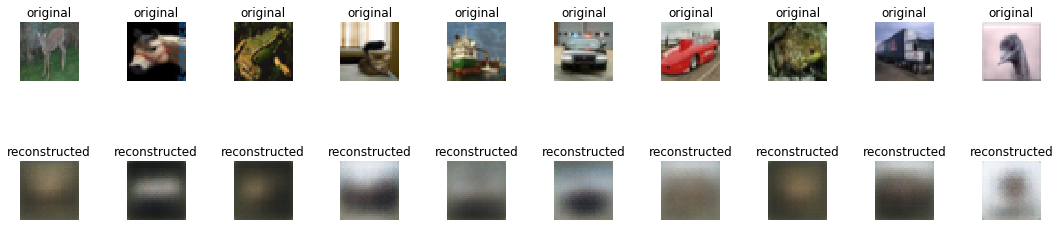

Training loss: 0.10546177900754489
Training loss: 0.09948782066886241
Training loss: 0.09802000679266759
Training loss: 0.09734182609961584
Training loss: 0.09650897823083095
Training loss: 0.09595938238960046
Training loss: 0.0953716376844125
Training loss: 0.09484239465151077
Training loss: 0.09445795972759907


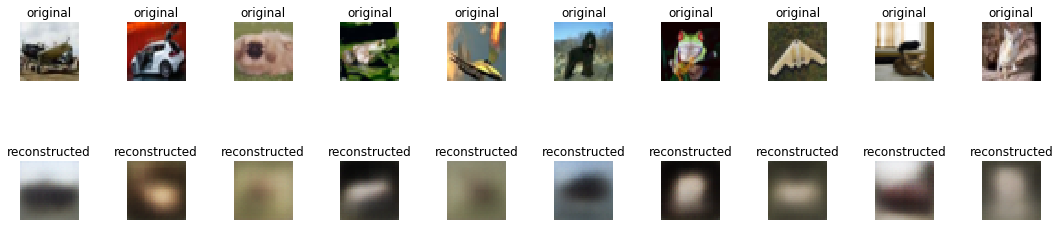

Training loss: 0.09419873780929125
Training loss: 0.09394592354312921
Training loss: 0.09167935433678139
Training loss: 0.08929863751698763
Training loss: 0.08891082984896806
Training loss: 0.08840861341510063
Training loss: 0.08815097547112367
Training loss: 0.08771287770225451
Training loss: 0.08753389523197443
Training loss: 0.08718496106373957


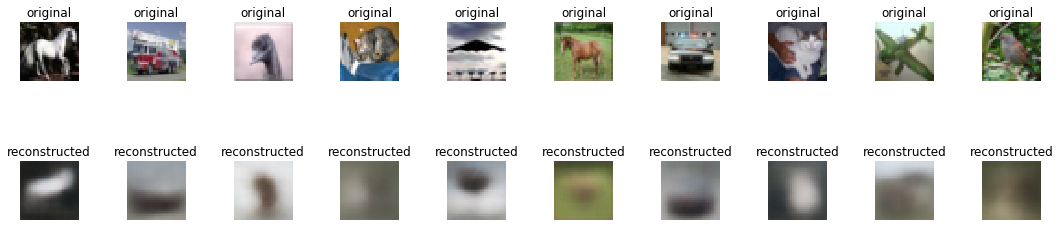

Training loss: 0.08710774823259085
Training loss: 0.08668927483451672
Training loss: 0.08648270087746474
Training loss: 0.08629552508011842
Training loss: 0.08609273357269091
Training loss: 0.08591417013070522
Training loss: 0.08584490212110372
Training loss: 0.08551077428154456
Training loss: 0.0854611384562957
Training loss: 0.08523495266070732


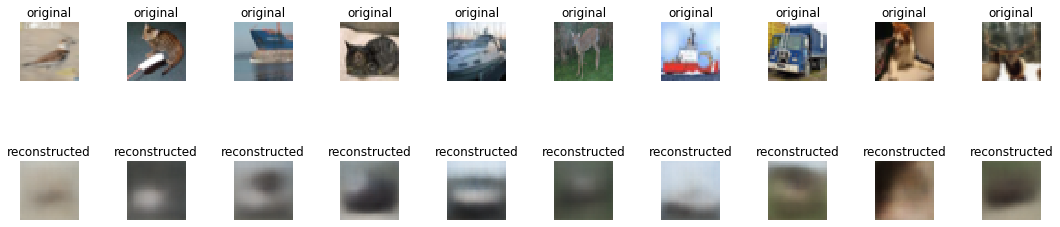

Training loss: 0.08505043137149933
Training loss: 0.08488205226185994
Training loss: 0.08480504168531834
Training loss: 0.08455231325366558
Training loss: 0.08449012839641326
Training loss: 0.08432881438579315
Training loss: 0.08420326977204054
Training loss: 0.08393684384914545
Training loss: 0.08385526876036938
Training loss: 0.08375952121538993


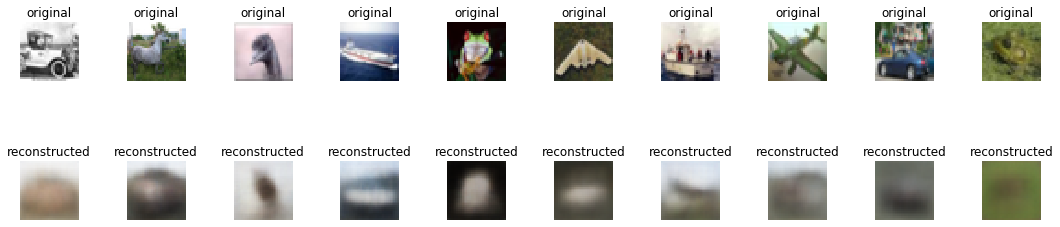

Training loss: 0.08365075956934538
Training loss: 0.08352330476045608
Training loss: 0.08326900009161387
Training loss: 0.08318550928662985
Training loss: 0.08302940311722266
Training loss: 0.08302038508730057
Training loss: 0.08285514148764121
Training loss: 0.08270032587341773
Training loss: 0.08258259605902891
Training loss: 0.08242896189674354


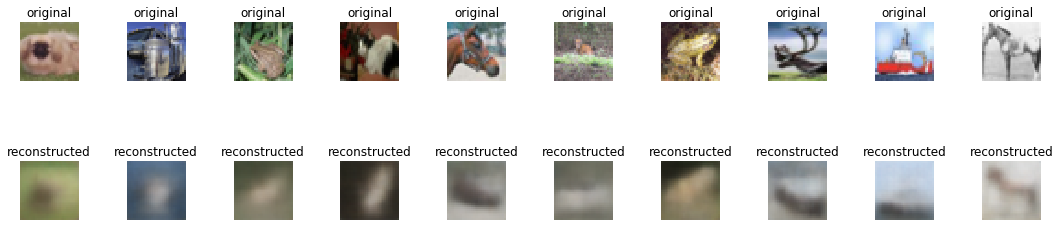

Training loss: 0.08233159887485016
Training loss: 0.08217973074851892
Training loss: 0.08205993758180202
Training loss: 0.08200700391943638
Training loss: 0.08179745030326721
Training loss: 0.08172389503854971
Training loss: 0.08163092927290844
Training loss: 0.08154565351895797
Training loss: 0.08140957649701681
Training loss: 0.08129851894500928


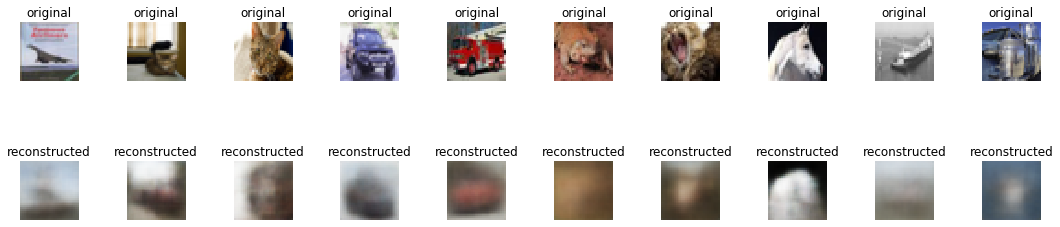

Training loss: 0.08124937136203815
Training loss: 0.08114934225495045
Training loss: 0.08101789194803971
Training loss: 0.08087766369183859
Training loss: 0.0807321150906575
Training loss: 0.08066404679646859
Training loss: 0.08055256373989277
Training loss: 0.08051528791204476
Training loss: 0.08037333112114516
Training loss: 0.08012888960731335


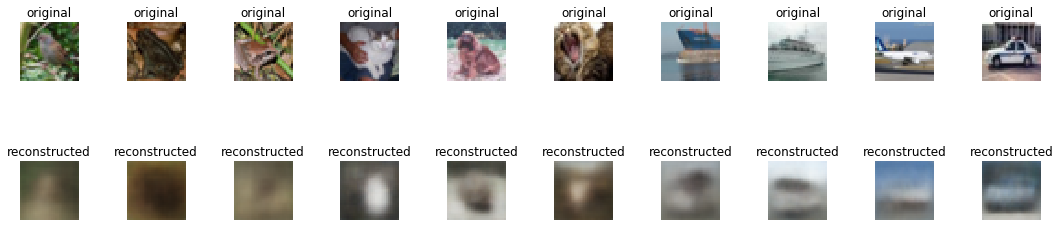

Training loss: 0.08016880958890303
Training loss: 0.07997778537563789
Training loss: 0.07998486780203305
Training loss: 0.07984490203551757
Training loss: 0.07969321241745582
Training loss: 0.07962705422288333
Training loss: 0.07954744646946589
Training loss: 0.07948576825169416
Training loss: 0.07935513202578594
Training loss: 0.0791999397942653


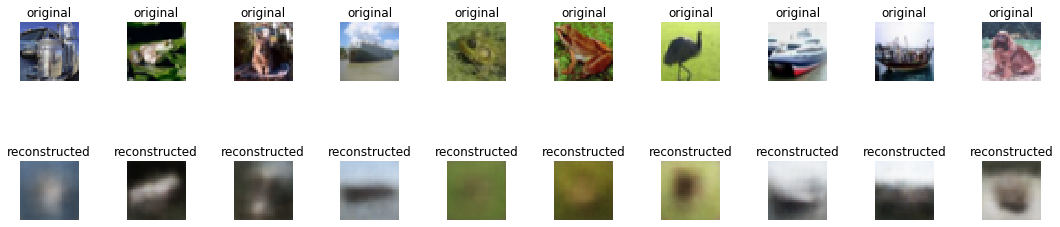

Training loss: 0.07917596239310044
Training loss: 0.07907116565948878
Training loss: 0.07827321932866023
Training loss: 0.07759156605372063
Training loss: 0.07734168981894468
Training loss: 0.0771325911848973
Training loss: 0.07700413943101199
Training loss: 0.07679202971168053
Training loss: 0.07665928281270541
Training loss: 0.07661572180879422


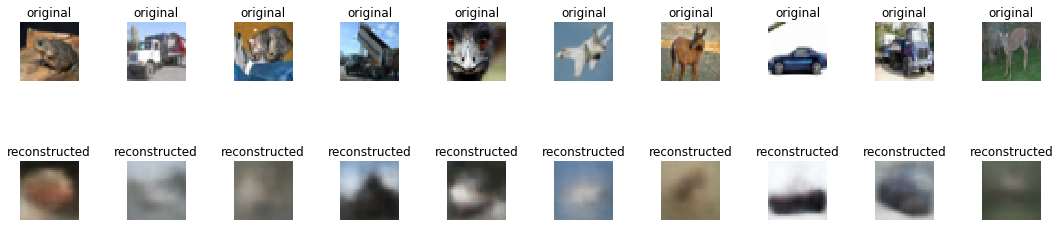

Training loss: 0.07644026338672026
Training loss: 0.07626455947756768
Training loss: 0.07613099670180908
Training loss: 0.07610497877765925
Training loss: 0.07596663920543133
Training loss: 0.07582654590025927
Training loss: 0.07582943951472258
Training loss: 0.07566040729482969
Training loss: 0.07552601175430493
Training loss: 0.07548324196384504


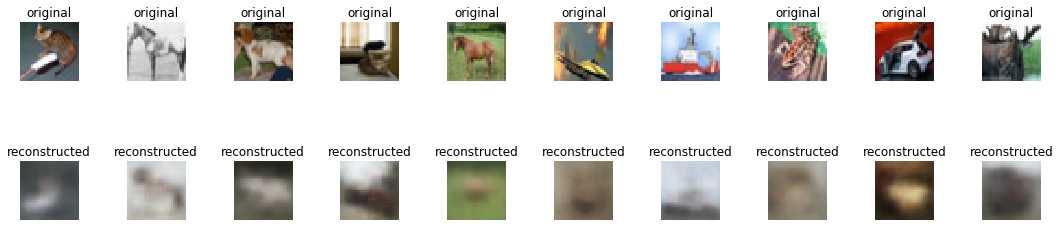

Training loss: 0.07536798446224285
Training loss: 0.07527442589784279
Training loss: 0.07508894035067314
Training loss: 0.0750245247895901
Training loss: 0.07495420040228427
Training loss: 0.07483376807127244
Training loss: 0.07472517455999668
Training loss: 0.07474046028577365
Training loss: 0.0746047460880035
Training loss: 0.07456054127751252


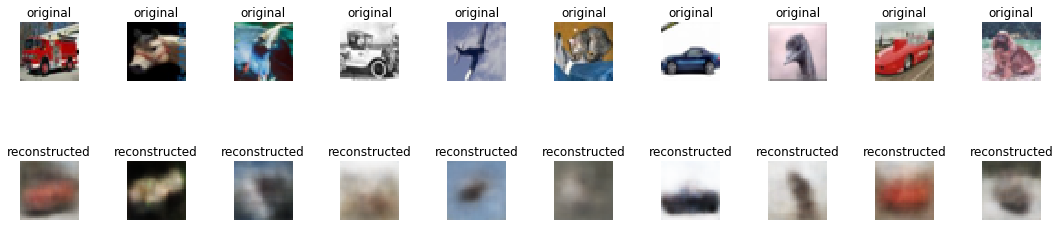

Training loss: 0.07443903042719914
Training loss: 0.07435718094691252
Training loss: 0.07420194999147685
Training loss: 0.07407870149383178
Training loss: 0.07405644076374861
Training loss: 0.0740003027786047
Training loss: 0.07391518606589391
Training loss: 0.07374745192818152
Training loss: 0.07374205212944593
Training loss: 0.07356602614506697


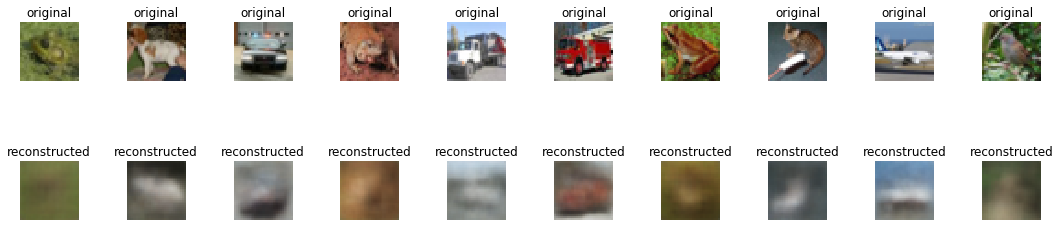

Training loss: 0.07352357705434164
Training loss: 0.07349564996667397
Training loss: 0.07329996018073498
Training loss: 0.07335436785450349
Training loss: 0.07330818474292755
Training loss: 0.07310131039374913
Training loss: 0.07314179937044779
Training loss: 0.07292244208928866
Training loss: 0.07283069726366263
Training loss: 0.07278354104894857


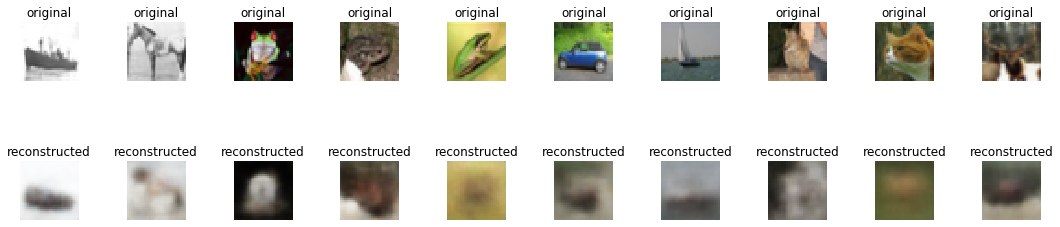

Training loss: 0.07275893884973648
Training loss: 0.07267380628066185
Training loss: 0.0725170568204843
Training loss: 0.07245717035272183
Training loss: 0.07247452825689928
Training loss: 0.07232586705149749
Training loss: 0.07232245842997845
Training loss: 0.07226051160922417
Training loss: 0.07207481396886019
Training loss: 0.07209593842809017


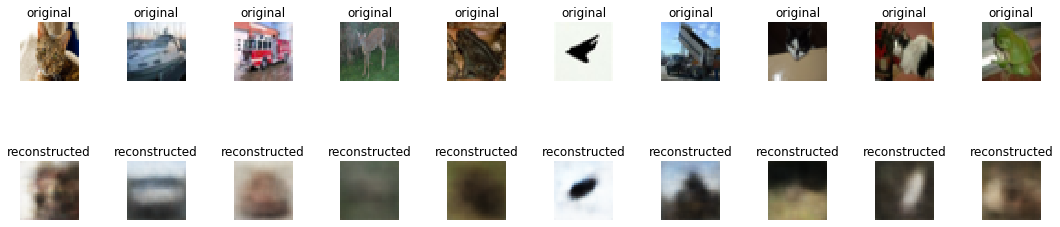

Training loss: 0.07204430972536405
Training loss: 0.0718827774700446
Training loss: 0.0718579586690817
Training loss: 0.07172936034890322
Training loss: 0.07177413083039798
Training loss: 0.0717089326144793
Training loss: 0.07154906023389254
Training loss: 0.0714835205521339
Training loss: 0.07142464864330414
Training loss: 0.07149874631028909


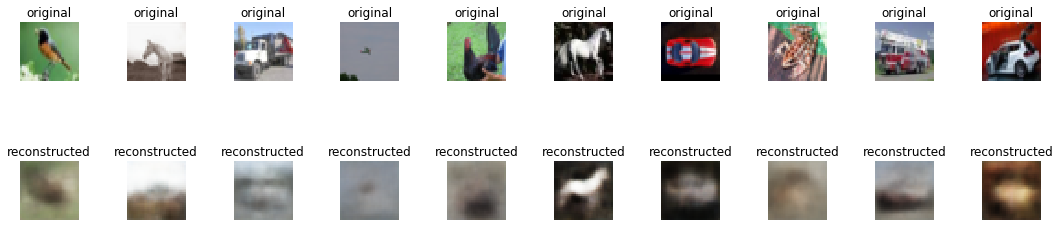

Training loss: 0.07131688619653384
Training loss: 0.07128423907053777
Training loss: 0.07116848377463145
Training loss: 0.07119755005607238
Training loss: 0.07111099440699968
Training loss: 0.07098579784998527
Training loss: 0.07096674014360477
Training loss: 0.07096457069691939
Training loss: 0.07085466486139175
Training loss: 0.07079715000895354


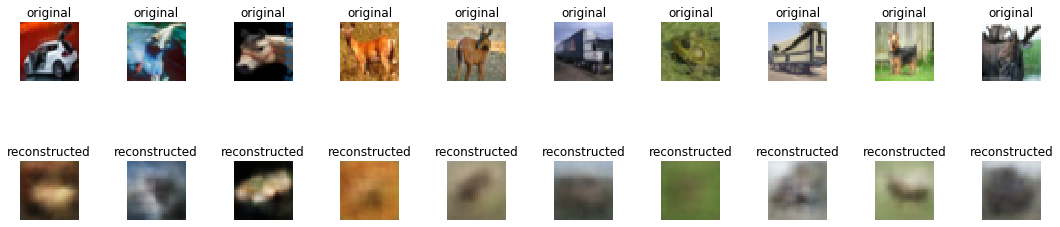

Training loss: 0.07069762660524784
Training loss: 0.0705395551923758
Training loss: 0.07057022480055308
Training loss: 0.07053790179391702
Training loss: 0.07046062470628665
Training loss: 0.07045476493927148
Training loss: 0.07040439431483929
Training loss: 0.0702619948448279
Training loss: 0.07024760708594933
Training loss: 0.07014267603174235


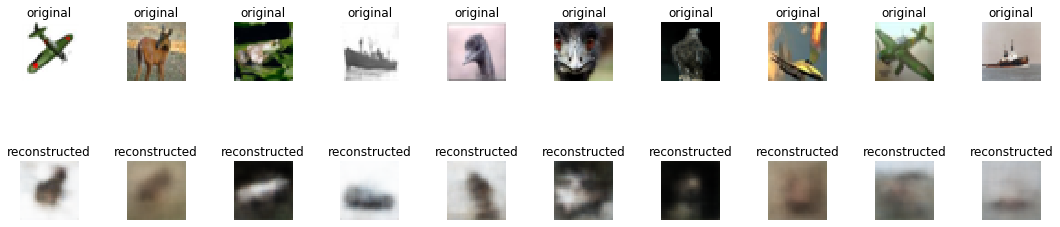

Training loss: 0.07012818958132695
Training loss: 0.07003204013483647
Training loss: 0.07006923829515775
Training loss: 0.06995473786806448
Training loss: 0.06980841851387269
Training loss: 0.0699284658027001
Training loss: 0.0697531568698394
Training loss: 0.06974056970614653
Training loss: 0.06969268878874106
Training loss: 0.06965498013947255


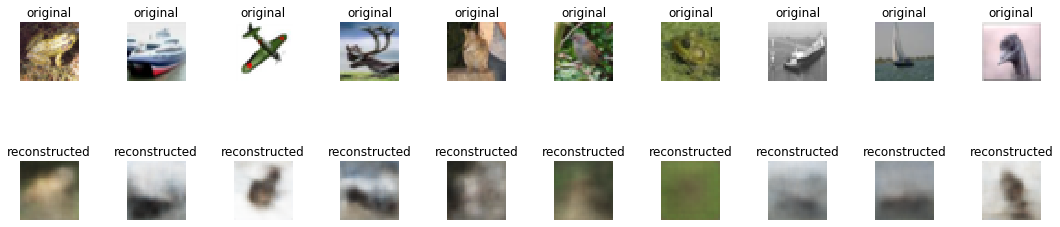

Training loss: 0.06954475505611836
Training loss: 0.06951705410312384
Training loss: 0.06952897367569116
Training loss: 0.06943936926814226
Training loss: 0.06930326352325769
Training loss: 0.06931596027734951
Training loss: 0.06929502606582948
Training loss: 0.069144156957284
Training loss: 0.0691267909338841
Training loss: 0.06901340584915418


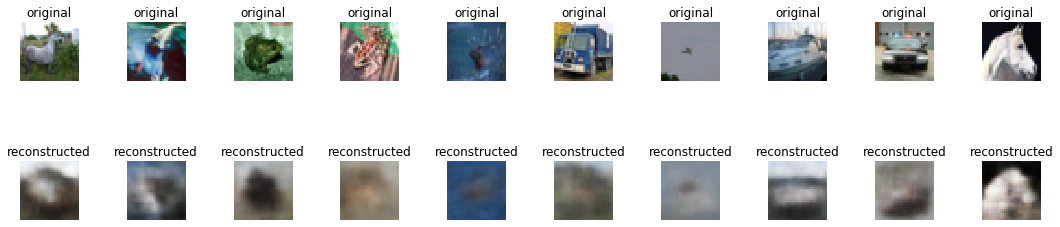

Training loss: 0.06905941504698533
Training loss: 0.06894853426477848
Training loss: 0.06908880571524302
Training loss: 0.06897259181699691
Training loss: 0.06890320270680464
Training loss: 0.06883615585855948
Training loss: 0.06877472127477328
Training loss: 0.06865904428637945
Training loss: 0.06864372932184966
Training loss: 0.06877704166257993


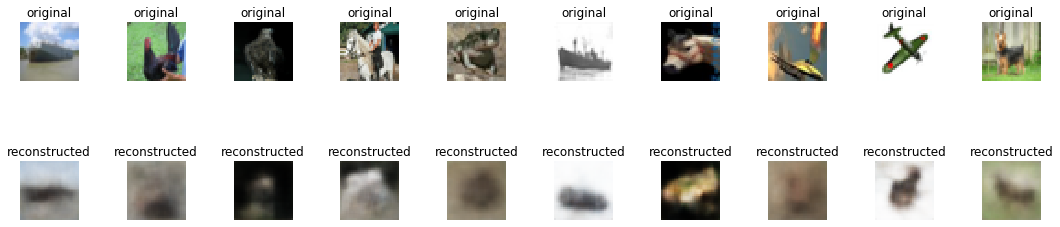

Training loss: 0.06857477830579647
Training loss: 0.0685876494512344
Training loss: 0.06846926476901923
Training loss: 0.06838125213980675
Training loss: 0.06828614024397654
Training loss: 0.06831306201907304
Training loss: 0.06836362072290518
Training loss: 0.06831009045052222
Training loss: 0.06820712585288745
Training loss: 0.06816896500113682


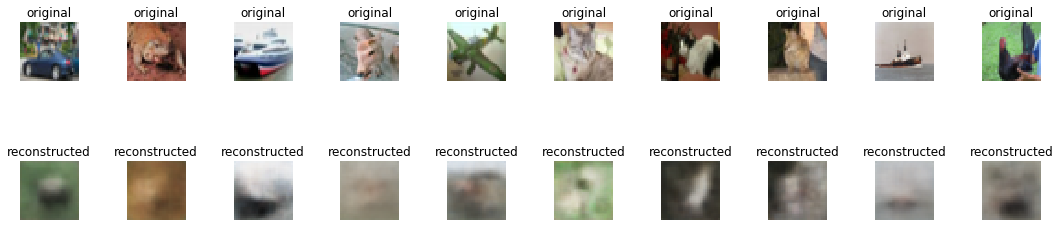

Training loss: 0.06811042761382384
Training loss: 0.06800435523574169
Training loss: 0.06800404250239715
Training loss: 0.06798093976118626
Training loss: 0.06793873422803023
Training loss: 0.06791781489856732
Training loss: 0.06784147591545031
Training loss: 0.06779065194229285
Training loss: 0.06772937584572877
Training loss: 0.06776151525286528


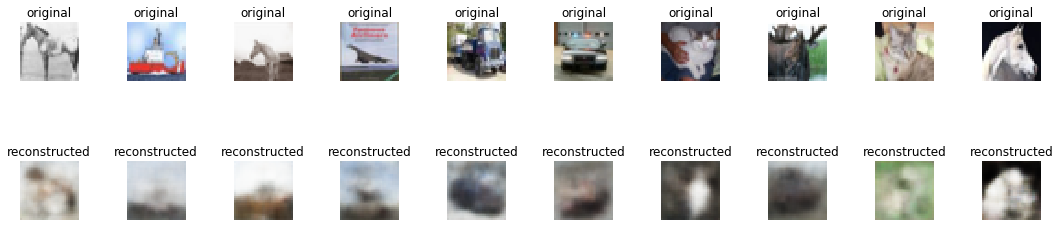

Training loss: 0.06773823307683835
Training loss: 0.06767851473429264
Training loss: 0.06766607195903093
Training loss: 0.0675089760373036
Training loss: 0.06751160852802106
Training loss: 0.06737006660073232
Training loss: 0.06742308853337398
Training loss: 0.06739251808478282
Training loss: 0.06730905443620988
Training loss: 0.06737073337038359


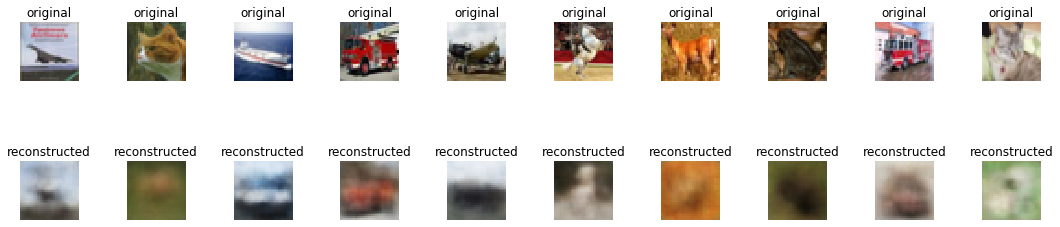

Training loss: 0.06723562937516432
Training loss: 0.067235120299917
Training loss: 0.06717455139717994
Training loss: 0.06723229866952468
Training loss: 0.06716160966226688
Training loss: 0.06696339928759978
Training loss: 0.06699576139067992
Training loss: 0.06701141647421396
Training loss: 0.06694974335722434
Training loss: 0.06693268048648651


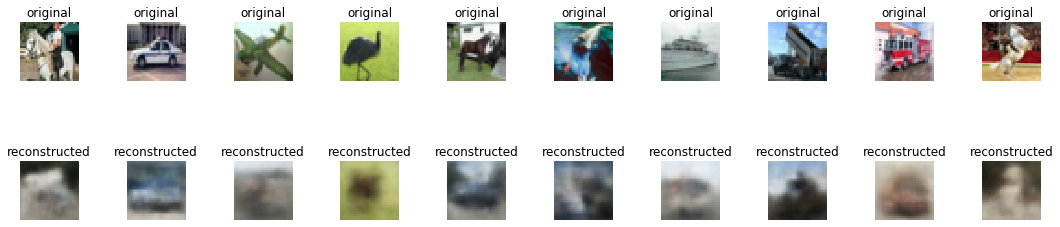

Training loss: 0.06684097564564301
Training loss: 0.06679561704588242
Training loss: 0.0667704545152493
Training loss: 0.06674296032541838
Training loss: 0.06671975942758414
Training loss: 0.06676977194654636
Training loss: 0.06671051101233715
Training loss: 0.0667030952202204
Training loss: 0.06656468347288096
Training loss: 0.06647276061658676


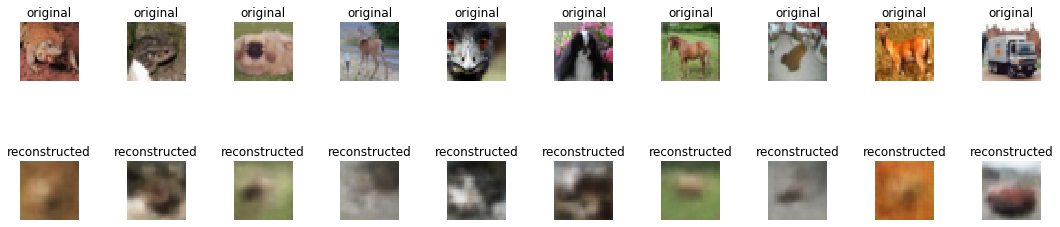

Training loss: 0.06657010495471649
Training loss: 0.06646417065117603
Training loss: 0.06646631148954232
Training loss: 0.06652914331509517
Training loss: 0.06640536812826608
Training loss: 0.06633182651339434
Training loss: 0.06636234444494431
Training loss: 0.06634591586696796
Training loss: 0.06626230377035264
Training loss: 0.06632027761676372


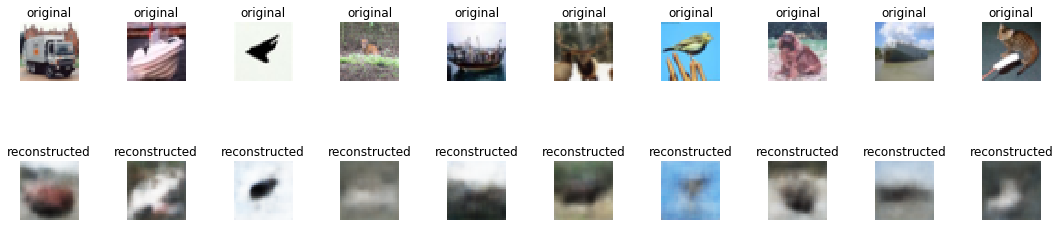

Training loss: 0.06623649766238836
Training loss: 0.0660824173153975
Training loss: 0.06616538828955247
Training loss: 0.06611684112785718
Training loss: 0.06608828592758913
Training loss: 0.06601341218711473
Training loss: 0.06601329944454706
Training loss: 0.06593675203621388
Training loss: 0.066017488285135
Training loss: 0.0659284869638773


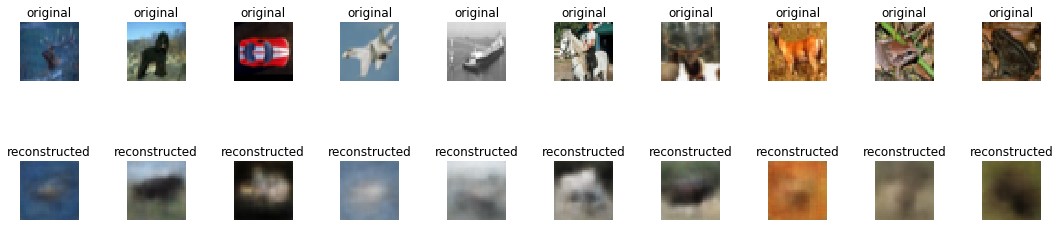

Training loss: 0.06583653222291898
Training loss: 0.06578201410862115
Training loss: 0.06590545165042082
Training loss: 0.065705173348005
Training loss: 0.06567726247967817
Training loss: 0.06576071265989389
Training loss: 0.06569860503077507
Training loss: 0.065662271854205
Training loss: 0.06552521572090113
Training loss: 0.065563995591723


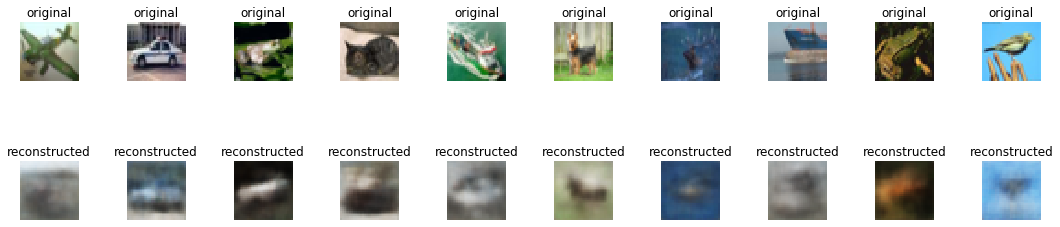

Training loss: 0.0655689253543432
Training loss: 0.065618515941195
Training loss: 0.06559763312912904
Training loss: 0.06547362240843284
Training loss: 0.06555287058536823
Training loss: 0.06533041892525478
Training loss: 0.06542969105335382
Training loss: 0.06546958372570001
Training loss: 0.0654381358757233
Training loss: 0.06523063729206721


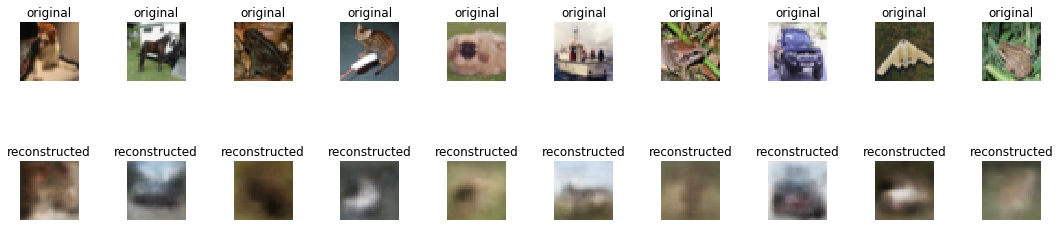

Training loss: 0.06530127064921917
Training loss: 0.06510902613592454
Training loss: 0.06525977931152552
Training loss: 0.06524606068164875
Training loss: 0.06520454451823846
Training loss: 0.06500070495292162
Training loss: 0.06517142120462198
Training loss: 0.0650339156198196
Training loss: 0.06505292522219511
Training loss: 0.0649390300974632


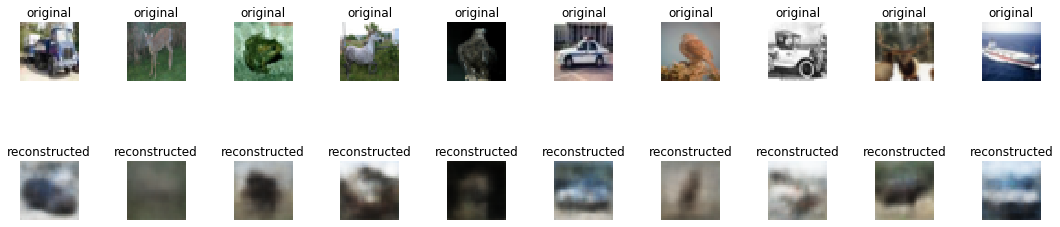

Training loss: 0.06505388204868023
Training loss: 0.0649191956489514
Training loss: 0.06489175483584404
Training loss: 0.06480494438646696
Training loss: 0.06487756132697448
Training loss: 0.06488806393284063
Training loss: 0.06480143590806386
Training loss: 0.06478489368007734
Training loss: 0.06466237785151371
Training loss: 0.06476232726604511


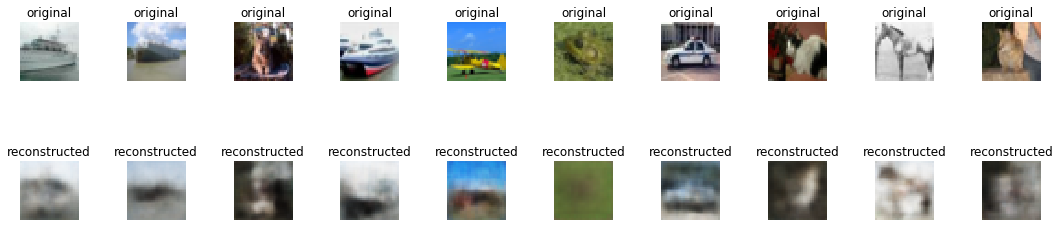

Training loss: 0.06468188359569281
Training loss: 0.0647336038068319
Training loss: 0.06471858067581286
Training loss: 0.0645985753585895
Training loss: 0.06458466211572672
Training loss: 0.06456792732843986
Training loss: 0.06454786718464815
Training loss: 0.06456170200537413
Training loss: 0.06445313934714367
Training loss: 0.06456045970702783


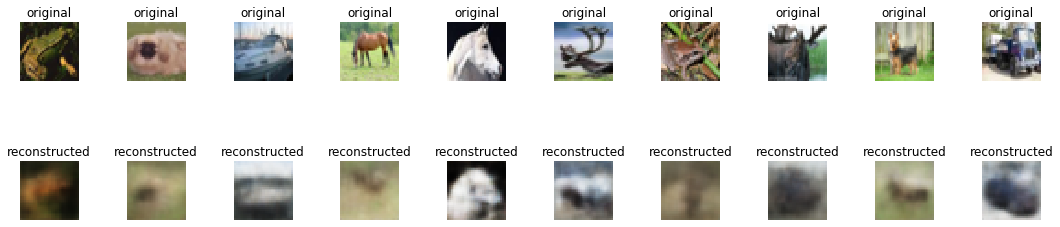

Training loss: 0.06443770494407568
Training loss: 0.06442943551601507
Training loss: 0.06435565685805603
Training loss: 0.06432529003001176
Training loss: 0.0643865821739802
Training loss: 0.06432595083919855
Training loss: 0.06442451296517482
Training loss: 0.06428667866648771
Training loss: 0.06420656325152287
Training loss: 0.06429181455228573


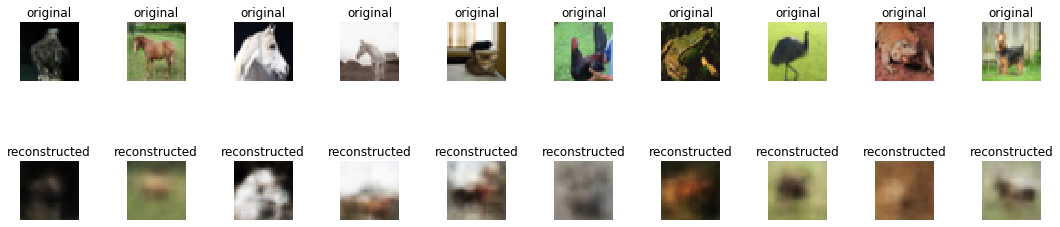

Training loss: 0.06420518559141036
Training loss: 0.06430179263727787
Training loss: 0.06411763557638878
Training loss: 0.06411386612707223
Training loss: 0.06412884060006875
Training loss: 0.064010540357767
Training loss: 0.0640064739741576
Training loss: 0.06406142204426803
Training loss: 0.06396140203070946
Training loss: 0.06405594810270346


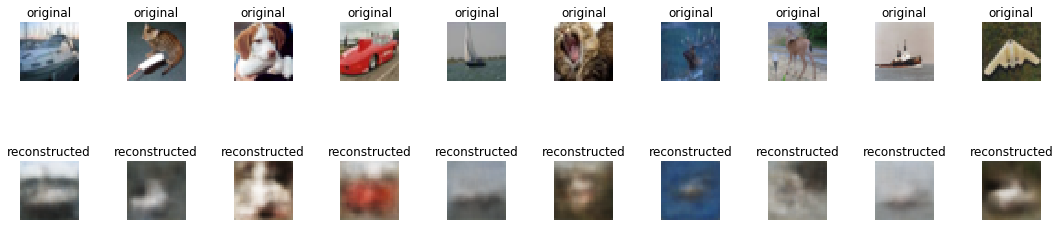

Training loss: 0.06400405854368821
Training loss: 0.06388443446694277
Training loss: 0.06392066964927393
Training loss: 0.06387637736132512
Training loss: 0.0640034367163212
Training loss: 0.06389678304967208
Training loss: 0.0637253772180814
Training loss: 0.06382121721712443
Training loss: 0.06369790691786852
Training loss: 0.06360863817807956


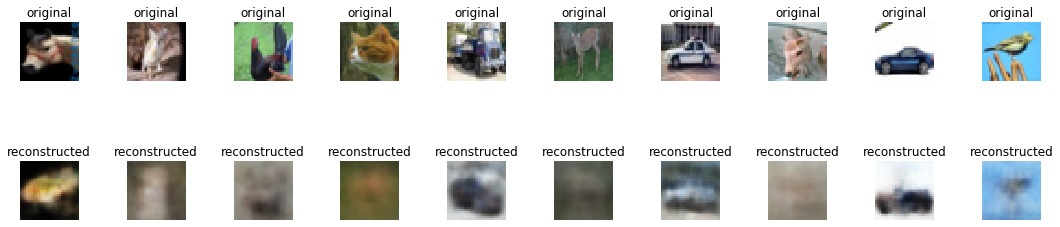

Training loss: 0.06369691057465016
Training loss: 0.06372161128391059
Training loss: 0.0636583404472241
Training loss: 0.06362213435081335
Training loss: 0.06364534633855025
Training loss: 0.0636762244388079
Training loss: 0.06359998011627259
Training loss: 0.06353375813326774
Training loss: 0.06356096006929875
Training loss: 0.06354408867848226


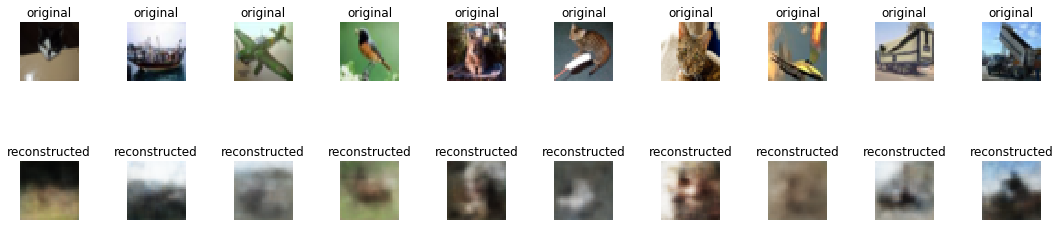

Training loss: 0.06350718166392583
Training loss: 0.06365271102732573
Training loss: 0.06348581828941137
Training loss: 0.0634940634171168
Training loss: 0.06342727070053418
Training loss: 0.06340859794081785
Training loss: 0.06349065992503594
Training loss: 0.0633239722595765
Training loss: 0.06337176931974216
Training loss: 0.06336373539689259


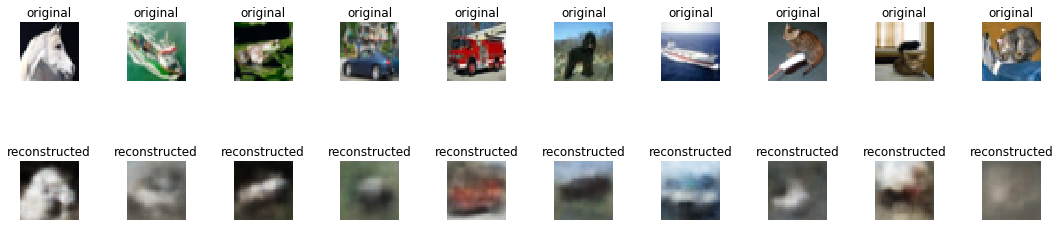

Training loss: 0.0632756533435522
Training loss: 0.06342346312908026
Training loss: 0.0632913504846585
Training loss: 0.06321437784876578
Training loss: 0.06327342055737972
Training loss: 0.06323723237101848
Training loss: 0.06312116053050909
Training loss: 0.06315494461510426
Training loss: 0.06317761819332074
Training loss: 0.06308521912075006


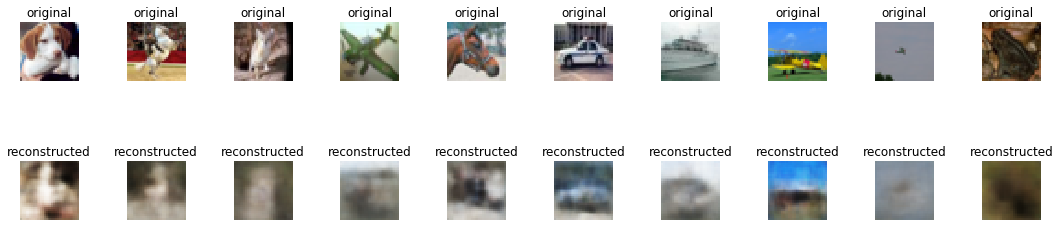

Training loss: 0.0630909066933852
Training loss: 0.06311053145581332
Training loss: 0.06294467992698535
Training loss: 0.06315052782495817
Training loss: 0.06311614373937631
Training loss: 0.06303828379664665
Training loss: 0.06304938885837029
Training loss: 0.06296187696548608
Training loss: 0.06299729718802831
Training loss: 0.06295318600650017


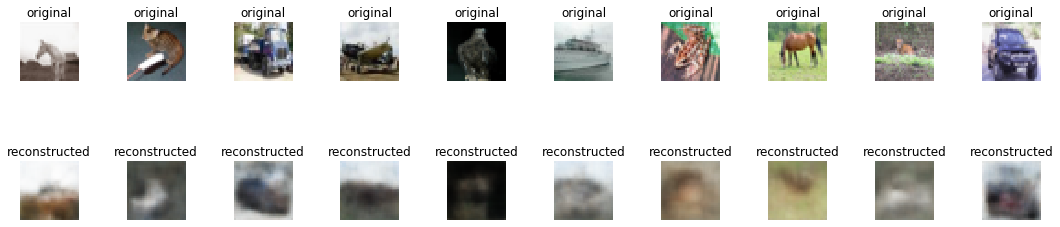

Training loss: 0.06284824750171258
Training loss: 0.06293699294328689
Training loss: 0.06290414282717766
Training loss: 0.0628357173063052
Training loss: 0.06279721681315165
Training loss: 0.06284765315552553
Training loss: 0.06279322214615651
Training loss: 0.06273698067435851
Training loss: 0.06265794875530097
Training loss: 0.0626950125854749


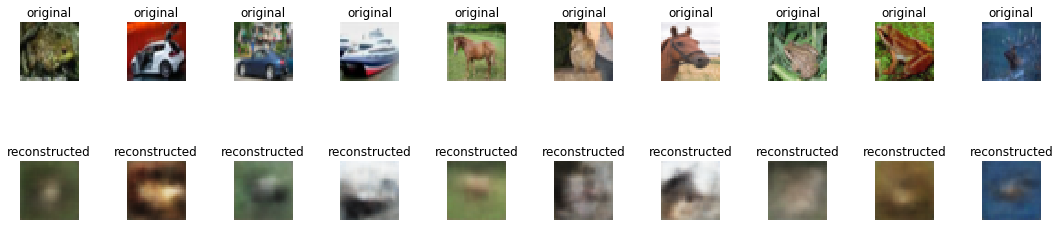

In [4]:
autoencoder = ConvAE_DCEC_Adjusted()

optimizer =  torch.optim.Adam(autoencoder.parameters(), lr=LR)

criterion =  nn.MSELoss() 

if USE_GPU:
    autoencoder.cuda()
    criterion.cuda()

for epoch in range(N_EPOCHS):
    autoencoder.train()
    losses = []
    for (X, _) in train_loader:
        if USE_GPU:
            X = X.cuda()
        
        optimizer.zero_grad()
        
    
        reconstruction = autoencoder(X)
        
        loss = criterion(X, reconstruction)
        
        loss.backward()

        losses = np.append(losses, loss.item())

        optimizer.step()

    autoencoder.eval()

    # print loss of train set
    print('Training loss: {}'.format(np.mean(losses)))

    # evaluation on test set 
    if ((epoch+1) % 10) == 0 or epoch == 0:
        X_test, _ = next(iter(test_loader))
        if USE_GPU:
            X_test = X_test.cuda()

        with torch.no_grad():
            reconstruction_test = autoencoder(X_test)

        loss = criterion(X_test, reconstruction_test)
        print('Test loss: {}'.format(loss), file=open('/dev/stdout', 'w')) # print to terminal for monitoring on gpu server

        # normalize to [0,1] for plotting
        X_test = to_img(X_test)
        reconstruction_test = to_img(reconstruction_test)
    
        # show some random images as well as some fixed images to may better see the progress
        fig, ax = plt.subplots(2, 10)
        fig.set_figwidth(15)
        fig.tight_layout()
        ax = ax.flatten()
        for i, index in enumerate(random.sample(range(len(X_test)),10)):
            img = X_test[index].cpu().numpy() # show noisy input for denoising autoencoder
            img_rec = reconstruction_test[index].cpu().numpy()
            ax[i].imshow(img.transpose(1,2,0))
            ax[i+10].imshow(img_rec.transpose(1,2,0))
            ax[i].set_title(f'original')
            ax[i+10].set_title(f'reconstructed')
            ax[i].set_axis_off()
            ax[i+10].set_axis_off()
        plt.show()

torch.save(autoencoder.state_dict(), "./convAE_DCED.pth")